In [3]:
import os
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset_3 import *
from dice_score import *
from model import *
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.utilities.seed import seed_everything
from pathlib import Path
from torchmetrics import Accuracy
from pytorch_lightning.loggers import WandbLogger
import matplotlib.colors as mcolors


import random

import matplotlib.pyplot as plt

In [4]:
# code du modèle :
class mon_modele(LightningModule):
    def __init__(self, n_channels, n_classes):
        super(mon_modele, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        #code here
        self.unet = UNet(n_channels, n_classes)
        self.save_hyperparameters()

    def forward(self, x):
        #code here
        return self.unet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        ce_loss = nn.CrossEntropyLoss(weight=torch.tensor([0.2,0.2,0.6])).cuda()
        loss = ce_loss(output, y)
        output = F.softmax(output, dim=1)
        dice = multiclass_dice_coeff(output.float(), F.one_hot(y,3).permute(0, 3, 1, 2).float())
        loss =  1 - dice
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        ce_loss = nn.CrossEntropyLoss(weight=torch.tensor([0.2,0.2,0.6])).cuda()
        loss = ce_loss(output, y)
        output = F.softmax(output, dim=1)
        dice = multiclass_dice_coeff(output.float(), F.one_hot(y,3).permute(0, 3, 1, 2).float())
        loss =  1 - dice
        self.log('val_loss', loss, prog_bar=True)



    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08)

In [5]:
def visualize_segmentation(img, ground_truth, prediction, class_labels):
    # Define the colors for each class
    colors = np.array([[0, 0, 0], [191, 191, 191], [255, 255, 255]])  
    # Function to map each class to its color
    def map_colors(image):
        color_mapped_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        for i in range(3):  # 3 classes: background, lung, pathology
            color_mapped_image[image == i] = colors[i]
        return color_mapped_image

    # Apply color mapping to ground truth and prediction
    ground_truth_colored = map_colors(ground_truth)
    prediction_colored = map_colors(prediction)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original Image
    axes[0].imshow(img.squeeze(), cmap='gray')
    axes[0].set_title("Original Image")
    
    # Ground Truth with Custom Colors
    axes[1].imshow(ground_truth_colored, alpha=0.7)
    axes[1].set_title("Ground Truth")
    
    # Prediction with Custom Colors
    axes[2].imshow(prediction_colored, alpha=0.7)
    axes[2].set_title("Prediction")

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
def main() :

  # Using deterministic execution
  seed_everything(42)


  #declarations variables fixes :
  dir_checkpoint = Path('./checkpoint_folder/')
  dir_data = Path('./dataset/Lung_dataset_256px.hdf5')


  in_channels = 1
  out_channels = 3
  batch_size = 32
  epochs = 30


  checkpoint_callback = ModelCheckpoint(
    dirpath=dir_checkpoint,
    filename="my_model-{epoch:03d}-{val_loss:.3f}.ckpt",
    save_top_k=2,
    verbose=True,
    monitor="val_loss",
    mode="min"
  )


  # 1 Create the data loader
  #take 20% of the dataset for validation
  PatientsIdTrain,PatientsIdVal = SelectPatientsTrainVal(dir_data, 0.2)
  #If classification type  = true : datagenerator for image classification
  #If classification type  = false : datagenerator for image segmentation
  train_ds = HDF5Dataset(dir_data,PatientsIdTrain,transform=None, classification_type=False)
  val_ds = HDF5Dataset(dir_data,PatientsIdVal,transform=None,mode='valid', classification_type=False)
  n_train = len(train_ds)
  n_val = len(val_ds)
  n_classes = 3

  # 2 - Create data loaders
  # params
  loader_params = dict(batch_size=batch_size,num_workers=4,pin_memory=True,shuffle=False)
  train_dl = DataLoader(train_ds,**loader_params)
  val_dl = DataLoader(val_ds,**loader_params)

  # load checkpoint from the checkpoint folder
  # model = mon_modele.load_from_checkpoint(f'./checkpoint_folder/my_model-epoch=026-val_loss=0.394.ckpt.ckpt', n_channels=in_channels, n_classes=n_classes)
  model = mon_modele.load_from_checkpoint(f'./checkpoint_folder/my_model-epoch=025-val_loss=0.458.ckpt.ckpt', n_channels=in_channels, n_classes=n_classes)

  model.eval()

  # Randomly sample 10 images from validation set
  sampled_indices = random.sample(range(len(val_ds)), 10)
  sampled_dataset = torch.utils.data.Subset(val_ds, sampled_indices)
  sampled_loader = DataLoader(sampled_dataset, batch_size=1, shuffle=False)

    # Visualize predictions
  for i, (x, y) in enumerate(sampled_loader):
      with torch.no_grad():
          pred = model(x)
          pred = F.softmax(pred, dim=1)
          pred = torch.argmax(pred, dim=1).squeeze() 
      visualize_segmentation(x.cpu().squeeze(), y.cpu().squeeze(), pred.cpu(), class_labels=['Background', 'Lung', 'COVID'])


Global seed set to 42


patientId shape  (192,)


100%|██████████| 60/60 [00:04<00:00, 12.13it/s]


dict_keys(['A-0202_0__dic_msk', 'A-0522__dic_msk', 'A-0319__dic_msk', 'A-0537__dic_msk', 'A-0422__dic_msk', 'A-0656__dic_msk', 'A-0070__dic_msk', 'A-0074_1__dic_msk', 'A-0072__dic_msk', 'A-0044__dic_msk', 'A-0323__dic_msk', 'A-0421__dic_msk', 'A-0288__dic_msk', 'A-0285__dic_msk', 'A-0569__dic_msk', 'A-0130__dic_msk', 'A-0548__dic_msk', 'A-0299__dic_msk', 'A-0418__dic_msk', 'A-0296__dic_msk', 'A-0635__dic_msk', 'A-0570__dic_msk', 'A-0445__dic_msk', 'A-0387__dic_msk', 'A-0295__dic_msk', 'A-0435__dic_msk', 'A-0106__dic_msk', 'A-0579__dic_msk', 'A-0263__dic_msk', 'A-0531__dic_msk', 'A-0423__dic_msk', 'A-0614__dic_msk', 'A-0077__dic_msk', 'A-0361__dic_msk', 'A-0629__dic_msk', 'A-0034__dic_msk', 'A-0504__dic_msk', 'A-0534__dic_msk', 'A-0612__dic_msk', 'A-0338__dic_msk', 'A-0416__dic_msk', 'A-0590__dic_msk', 'A-0165__dic_msk', 'A-0521__dic_msk', 'A-0196_0__dic_msk', 'A-0665__dic_msk', 'A-0392__dic_msk', 'A-0247__dic_msk', 'A-0316__dic_msk', 'A-0476__dic_msk', 'A-0129__dic_msk', 'A-0575__dic_m

100%|██████████| 38/38 [00:03<00:00, 10.58it/s]


dict_keys(['A-0511__dic_msk', 'A-0623__dic_msk', 'A-0652__dic_msk', 'A-0270__dic_msk', 'A-0246__dic_msk', 'A-0413__dic_msk', 'A-0236__dic_msk', 'A-0686__dic_msk', 'A-0255__dic_msk', 'A-0228__dic_msk', 'A-0355__dic_msk', 'A-0090__dic_msk', 'A-0252__dic_msk', 'A-0586__dic_msk', 'A-0670__dic_msk', 'A-0494__dic_msk', 'A-0173__dic_msk', 'A-0576__dic_msk', 'A-0660__dic_msk', 'A-0011__dic_msk', 'A-0239__dic_msk', 'A-0560__dic_msk', 'A-0495__dic_msk', 'A-0566__dic_msk', 'A-0397__dic_msk', 'A-0388__dic_msk', 'A-0437__dic_msk', 'A-0354__dic_msk', 'A-0315__dic_msk', 'A-0463__dic_msk', 'A-0698__dic_msk', 'A-0083__dic_msk', 'A-0307__dic_msk', 'A-0407__dic_msk', 'A-0066__dic_msk', 'A-0372__dic_msk', 'A-0658__dic_msk', 'A-0394__dic_msk'])


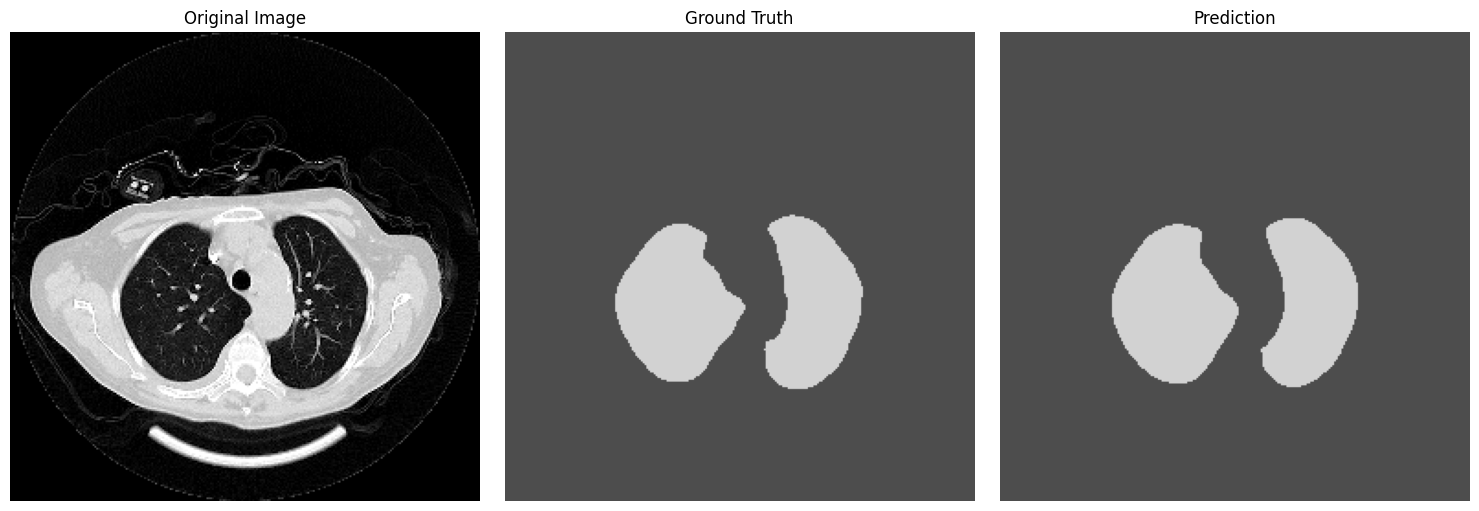

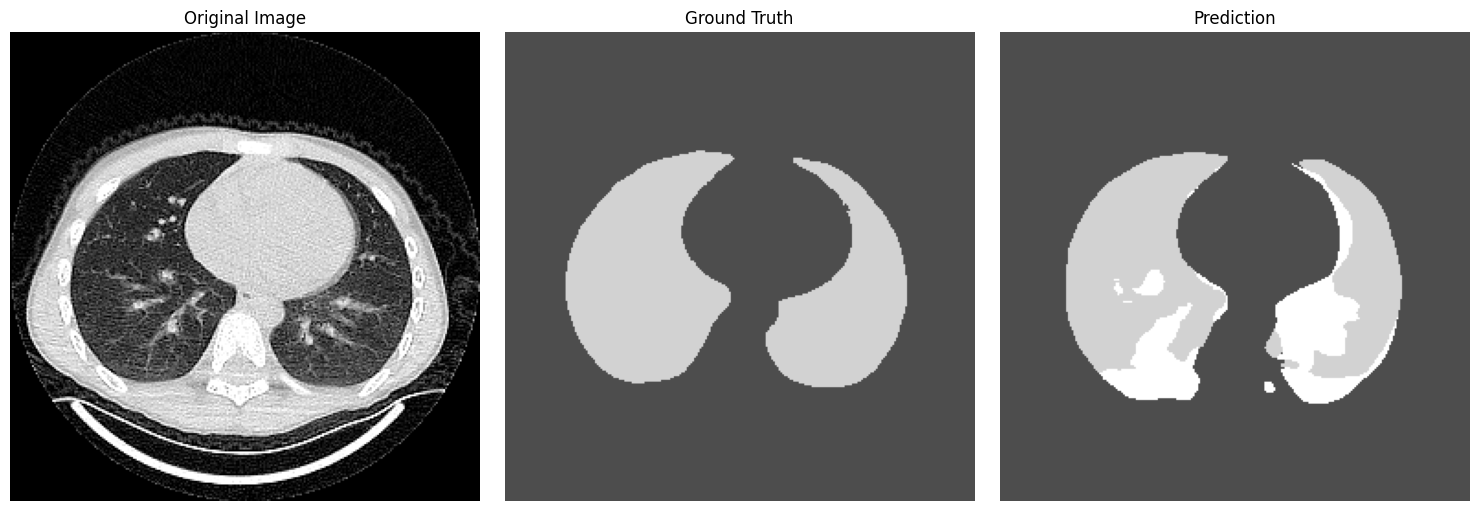

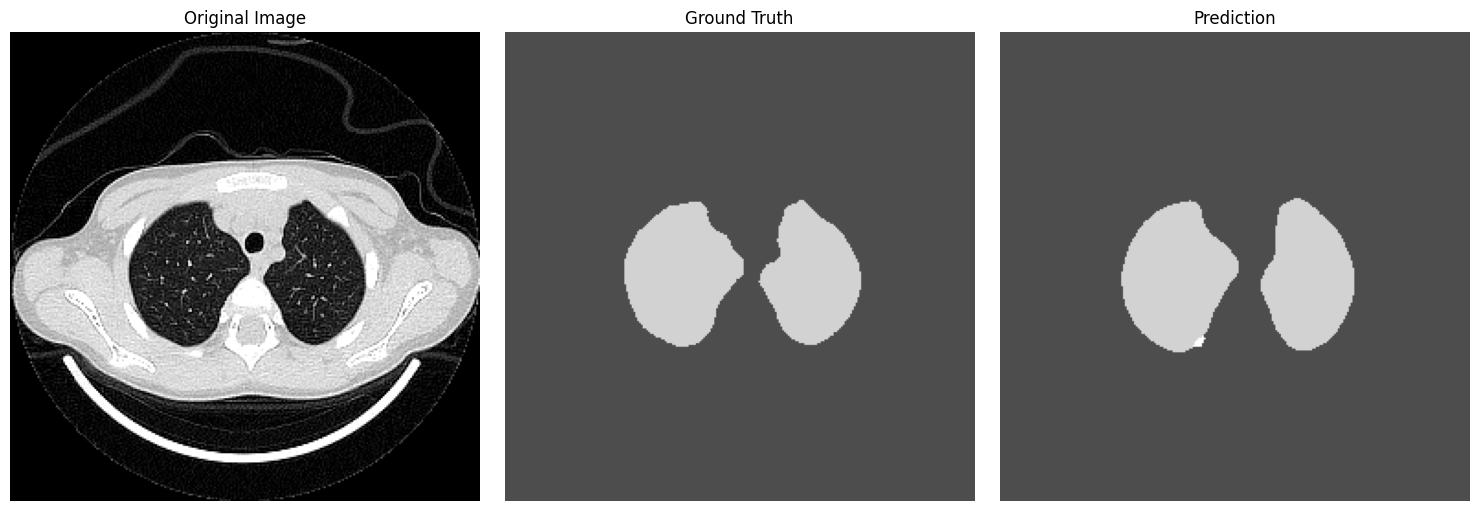

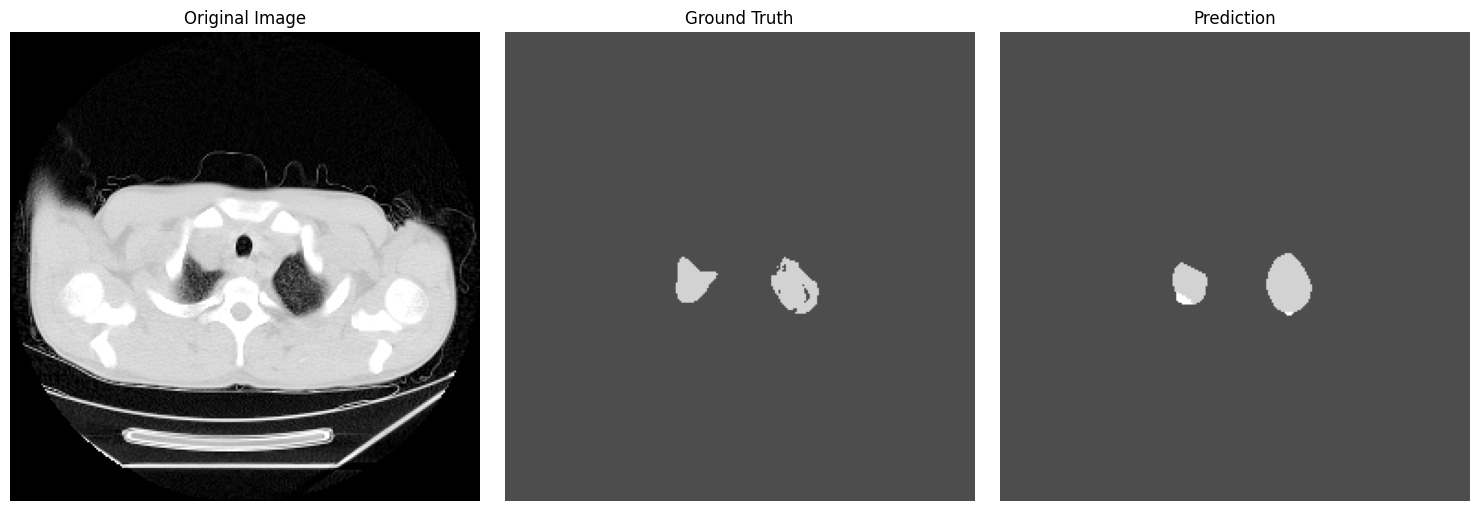

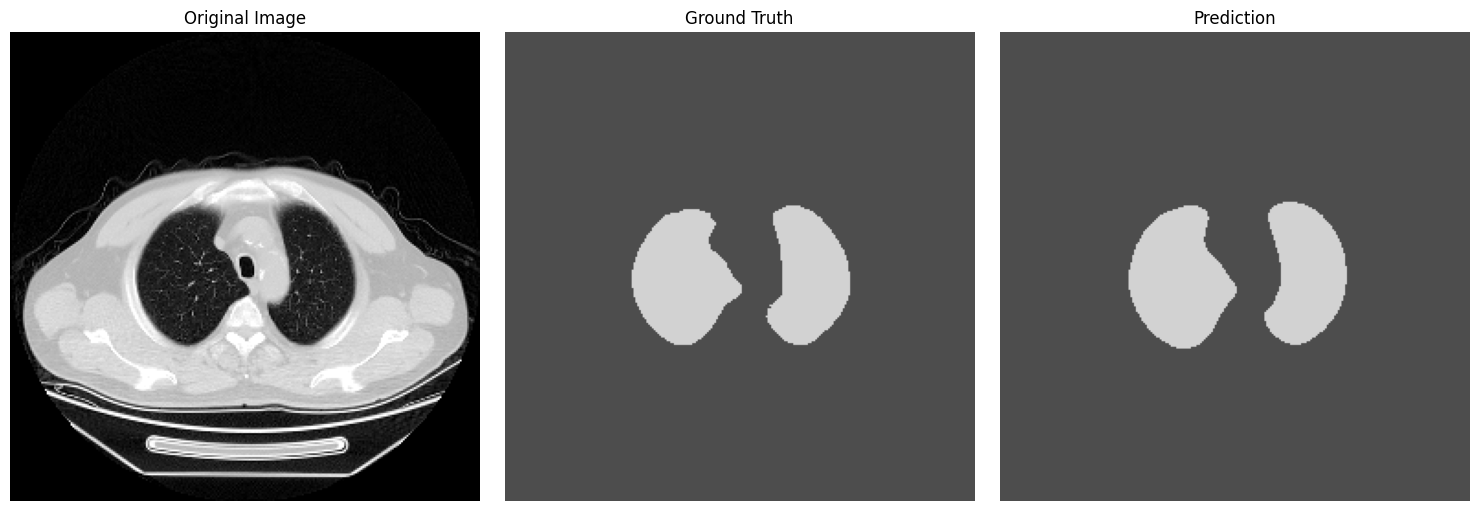

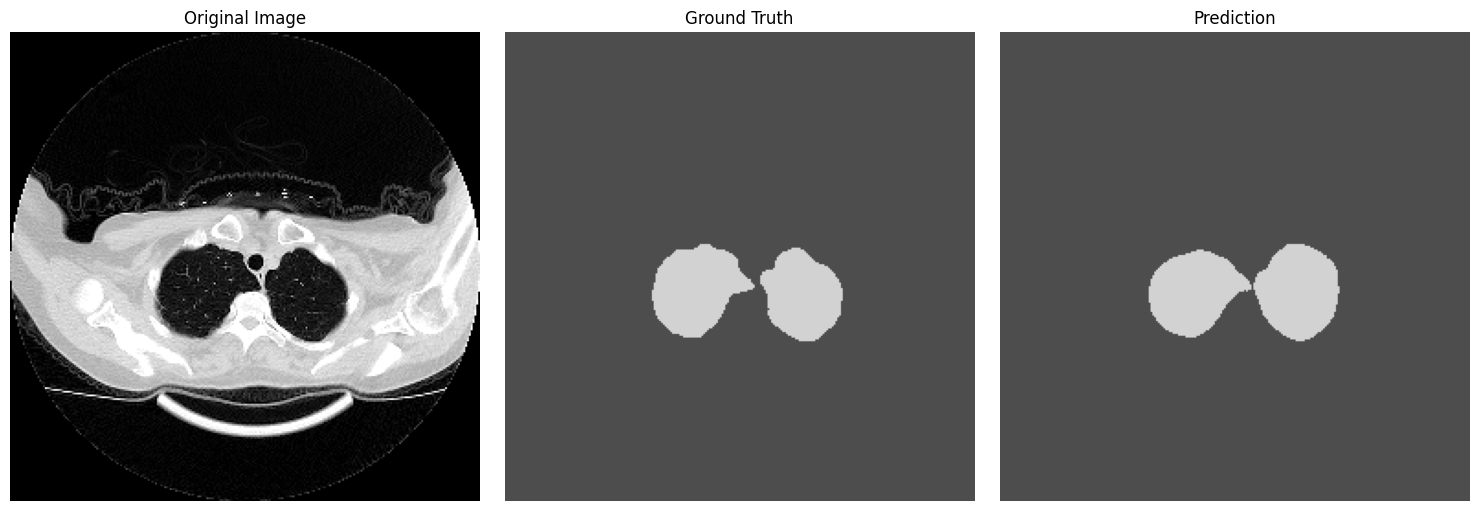

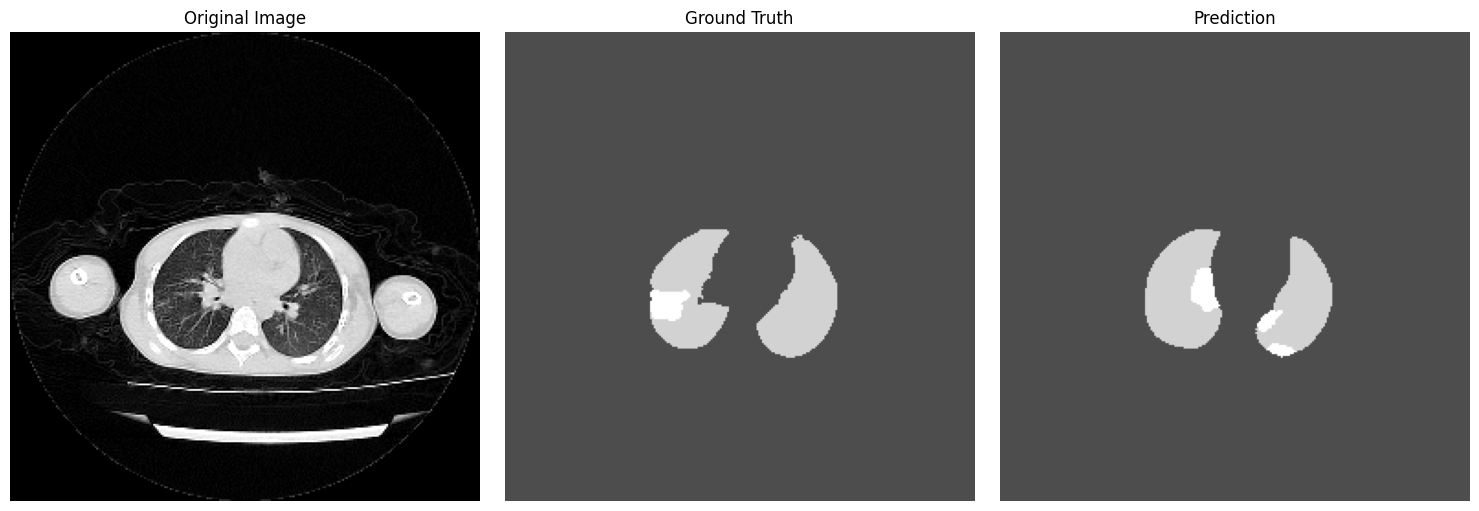

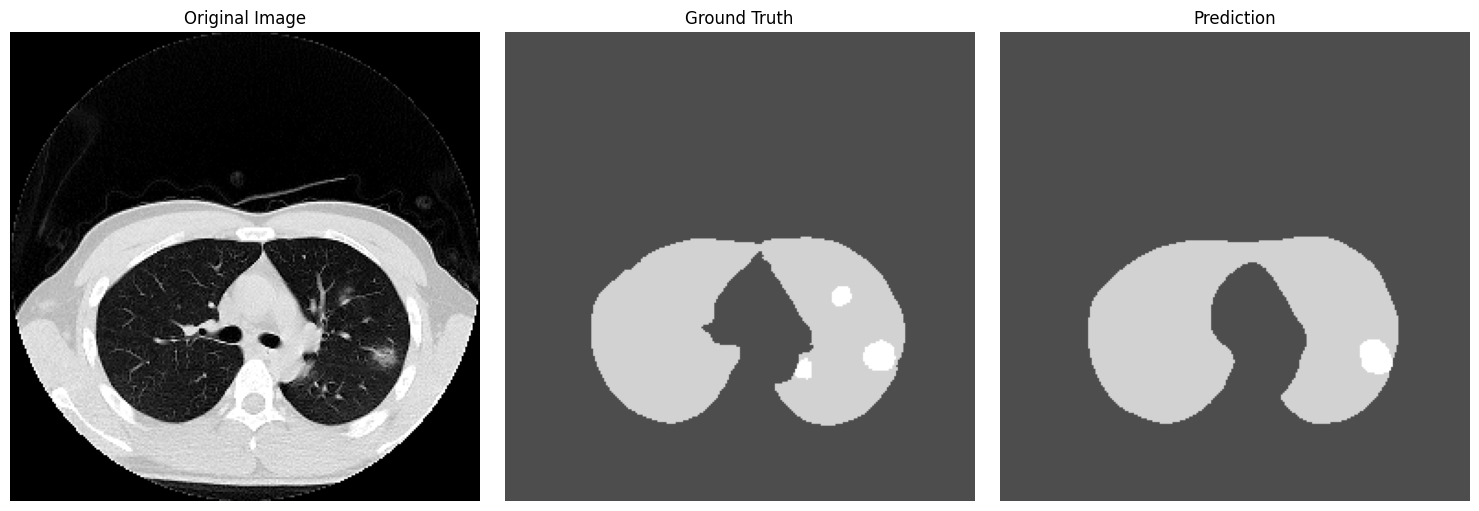

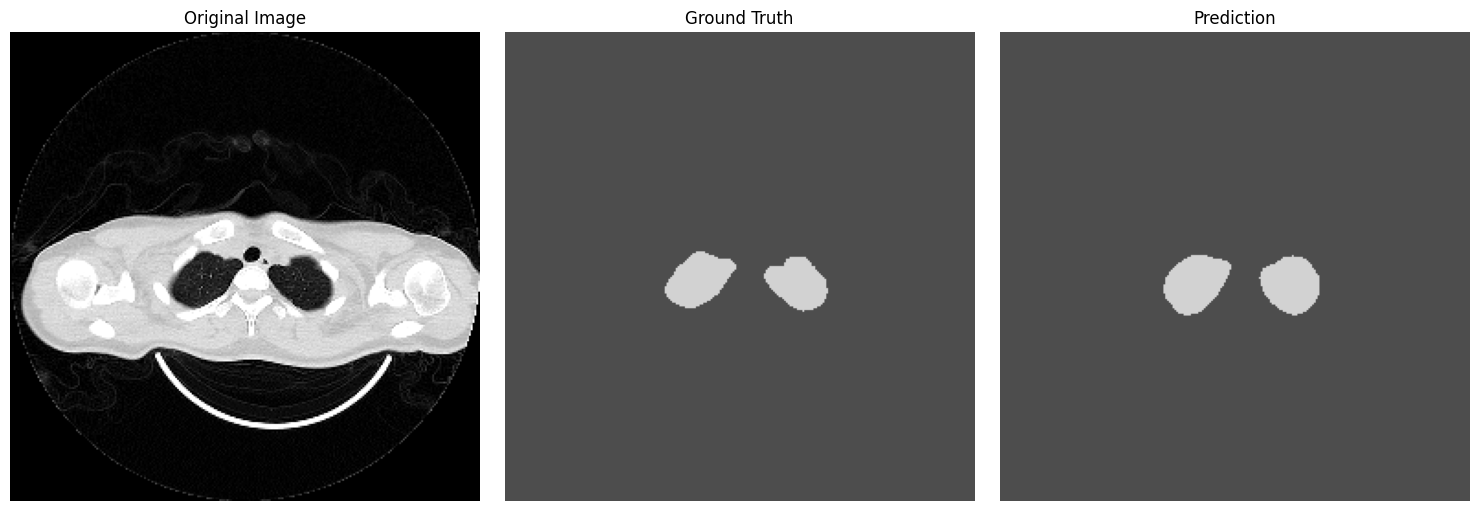

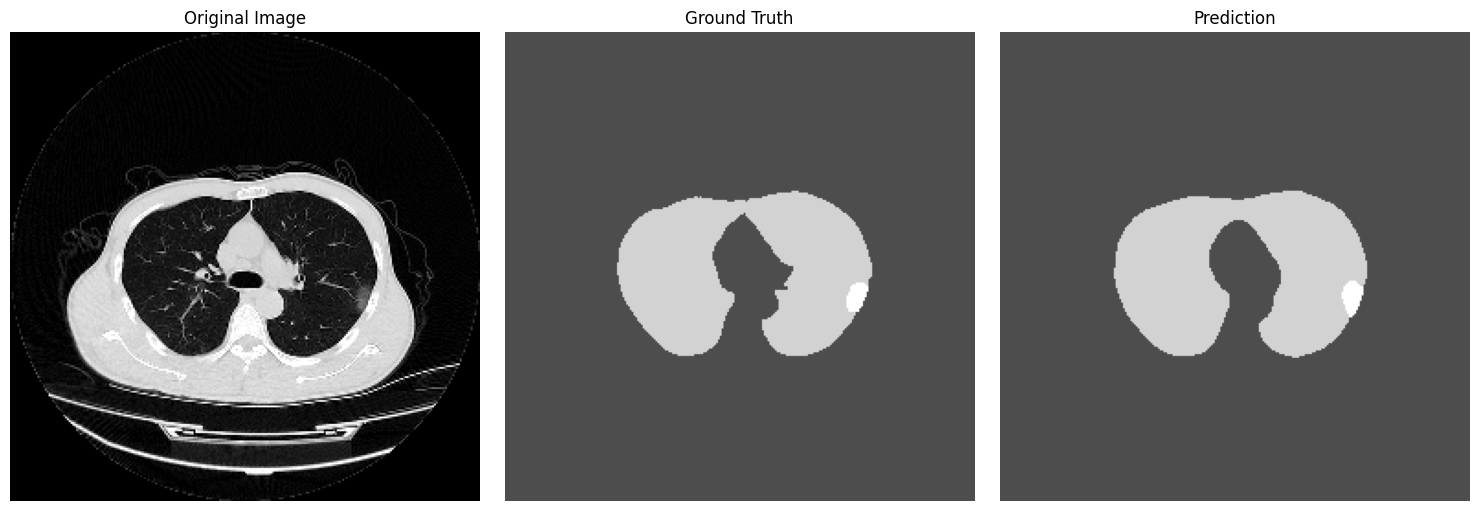

In [9]:
if __name__ == '__main__':
    main()